# Experiment With Various Models

In [35]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

import os

print('Done')

Done


### Set up the file directory

In [22]:
colon_dir='../data/SpringBoard/lung_colon_image_set/colon_image_sets/'
lung_dir='../data/SpringBoard/lung_colon_image_set/lung_image_sets/'
lung_aca='../data/SpringBoard/lung_colon_image_set/lung_image_sets/lung_aca/'
lung_n='../data/SpringBoard/lung_colon_image_set/lung_image_sets/lung_n/'
lung_scc='../data/SpringBoard/lung_colon_image_set/lung_image_sets/lung_scc/'

In [4]:
SIZE_X=SIZE_Y=224
data=ImageDataGenerator(validation_split = 0.3)
BATCH_SIZE = 128

training=data.flow_from_directory(lung_dir,
                                  class_mode = "categorical",
                                  target_size = (SIZE_X,SIZE_Y),
                                  color_mode="rgb",
                                  batch_size = 128, 
                                  shuffle = False,
                                  subset='training',
                                  seed = 42)

validation=data.flow_from_directory(lung_dir,
                                    class_mode = "categorical",
                                    target_size = (SIZE_X,SIZE_Y),
                                    color_mode="rgb",
                                    batch_size = 128, 
                                    shuffle = False,
                                    subset='validation',
                                    seed = 42)

Found 4200 images belonging to 3 classes.
Found 1800 images belonging to 3 classes.


# Choosing and training the model
### Using three neural networks 
### 1: VGG 16
### 2: InceptionV3
### 3: ResNet50

In [5]:
# VGG 16

def create_model(input_shape,n_classes,optimizer='adam',fine_tune=0):
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)

    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(256, activation='relu')(top_model)
    top_model = Dense(128, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model) # We add a dropout here to prevent overfitting
    output_layer = Dense(3, activation='softmax')(top_model)
    model = Model(inputs=conv_base.input, outputs=output_layer)
    
    model.compile(optimizer = 'adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [6]:
input_shape=(224,224,3)
optim_1 = Adam(learning_rate=0.0001)
n_classes=3

n_steps=training.samples//128
n_val_steps=validation.samples//128
n_epochs=5

vggmodel=create_model(input_shape,n_classes,optim_1,fine_tune=2)

58892288/58889256 [==============================] - 15s 0us/step


In [7]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [8]:
%%time 

vgg_history = vggmodel.fit(training,
                           batch_size=BATCH_SIZE,
                           epochs=n_epochs,
                           validation_data=(validation),
                           steps_per_epoch=n_steps,
                           validation_steps=n_val_steps,
                           callbacks=[tl_checkpoint_1, early_stop],
                           verbose=1)

Epoch 1/5
32/32 [==============================] - 1279s 41s/step - loss: 15.1920 - accuracy: 0.4740 - val_loss: 0.6087 - val_accuracy: 0.7762

Epoch 00001: val_loss improved from inf to 0.60871, saving model to tl_model_v1.weights.best.hdf5
Epoch 2/5
32/32 [==============================] - 1248s 39s/step - loss: 0.4656 - accuracy: 0.8418 - val_loss: 0.3338 - val_accuracy: 0.8655

Epoch 00002: val_loss improved from 0.60871 to 0.33380, saving model to tl_model_v1.weights.best.hdf5
Epoch 3/5
32/32 [==============================] - 1573s 50s/step - loss: 2.1566 - accuracy: 0.7269 - val_loss: 2.6856 - val_accuracy: 0.7188

Epoch 00003: val_loss did not improve from 0.33380
Epoch 4/5
32/32 [==============================] - 1300s 41s/step - loss: 0.5022 - accuracy: 0.8689 - val_loss: 0.2520 - val_accuracy: 0.9062

Epoch 00004: val_loss improved from 0.33380 to 0.25197, saving model to tl_model_v1.weights.best.hdf5
Epoch 5/5
32/32 [==============================] - 1146s 36s/step - loss: 

### Plot the performance of the model, the loss and the accuracy rate as the model is being trained

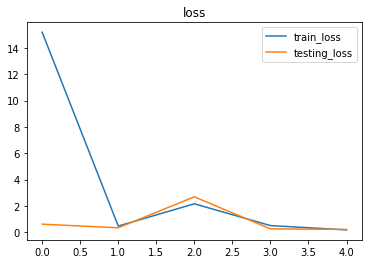

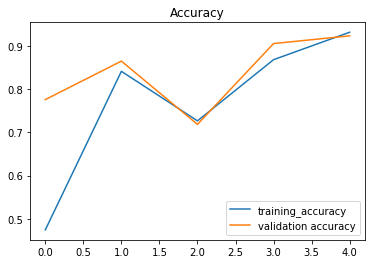

In [9]:
plt.plot(vgg_history.history['loss'],label = 'train_loss')
plt.plot(vgg_history.history['val_loss'], label = 'testing_loss')
plt.title('loss')
plt.legend()
plt.show()

plt.plot(vgg_history.history['accuracy'], label='training_accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

### Calculate the accuracy rate of this model

In [10]:
vggmodel.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = validation.classes
class_indices = training.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vggmodel.predict(validation)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

In [11]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}".format(vgg_acc))

VGG16 Model Accuracy with Fine-Tuning: 0.92


### Training model with InceptionV3

In [12]:
# InceptionV3

input_shape=(224,224,3)

n_classes=3

base_model=InceptionV3(weights='imagenet',
                      include_top=False,
                      input_shape=(224,224,3))
# This is to ensure the base won't be trained again
base_model.trainable=False

add_model=Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.2)) # We add a dropout here to prevent overfitting
add_model.add(Dense(n_classes,
                   activation='softmax'))

inceptionmodel=add_model

87916544/87910968 [==============================] - 14s 0us/step


### Compile the model with the same configuration as above

In [13]:
inceptionmodel.compile(loss='categorical_crossentropy',
                      optimizer = 'adam',
                      metrics=['accuracy'])
inceptionmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


In [14]:
file_path="weights.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early = EarlyStopping(monitor="val_loss", mode="min", patience=10)

callbacks_list = [checkpoint, early]

# Fit the model with the same configuration as above
inceptionhistory=inceptionmodel.fit(training,
                                   epochs=5,
                                   validation_data=(validation),
                                   verbose=1,
                                   callbacks=callbacks_list)

Epoch 1/5
33/33 [==============================] - 243s 7s/step - loss: 22.0275 - accuracy: 0.4124 - val_loss: 4.2722 - val_accuracy: 0.5806

Epoch 00001: val_loss improved from inf to 4.27220, saving model to weights.best.hdf5
Epoch 2/5
33/33 [==============================] - 233s 7s/step - loss: 13.5037 - accuracy: 0.4802 - val_loss: 11.9608 - val_accuracy: 0.5778

Epoch 00002: val_loss did not improve from 4.27220
Epoch 3/5
33/33 [==============================] - 250s 8s/step - loss: 11.4044 - accuracy: 0.5274 - val_loss: 3.4145 - val_accuracy: 0.6656

Epoch 00003: val_loss improved from 4.27220 to 3.41447, saving model to weights.best.hdf5
Epoch 4/5
33/33 [==============================] - 262s 8s/step - loss: 7.5249 - accuracy: 0.6129 - val_loss: 8.7544 - val_accuracy: 0.5278

Epoch 00004: val_loss did not improve from 3.41447
Epoch 5/5
33/33 [==============================] - 256s 8s/step - loss: 9.3186 - accuracy: 0.5302 - val_loss: 3.1228 - val_accuracy: 0.6911

Epoch 00005: 

#### Plot the performance of the model as it is being trained

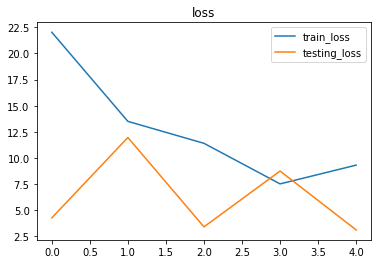

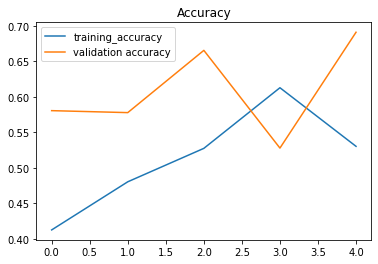

In [15]:
plt.plot(inceptionhistory.history['loss'],label = 'train_loss')
plt.plot(inceptionhistory.history['val_loss'], label = 'testing_loss')
plt.title('loss')
plt.legend()
plt.show()

plt.plot(inceptionhistory.history['accuracy'], label='training_accuracy')
plt.plot(inceptionhistory.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [16]:
inceptionresult=inceptionmodel.evaluate(validation,batch_size=128)
print(f'The test loss for InceptionV3 is {"{:.2f}".format(inceptionresult[0])} and the test accuracy is {"{:.2f}".format(inceptionresult[1])}')

15/15 [==============================] - 71s 5s/step - loss: 3.1228 - accuracy: 0.6911
The test loss for InceptionV3 is 3.12 and the test accuracy is 0.69


### Training model with ResNet 50

In [17]:
# ResNet50
Image_Size=[224,224]

resnet=Sequential()

resnet.add(ResNet50(input_shape=Image_Size+[3],weights='imagenet',include_top=False,pooling='average'))

# This is to ensure the base won't be trained again
for layer in resnet.layers:
    layer.trainable=False
    
flatten=Flatten()(resnet.output)
dense=Dense(256,activation='relu')(flatten)
dense=Dense(128,activation='relu')(dense)
dense=Dropout(0.2)(dense)   # We add a dropout here to prevent overfitting
prediction=Dense(3,activation='softmax')(dense)

resmodel=Model(inputs=resnet.input,outputs=prediction)

resmodel.summary()

94773248/94765736 [==============================] - 25s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50_input (InputLayer)  [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
___________________________________________________________

In [18]:
# complile the model

resmodel.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [19]:
# fit the model to the data with the same configuration
reshistory=resmodel.fit(training,validation_data=(validation),epochs=5,verbose=1)

Epoch 1/5
33/33 [==============================] - 502s 15s/step - loss: 41.2875 - accuracy: 0.6136 - val_loss: 20.7930 - val_accuracy: 0.6461
Epoch 2/5
33/33 [==============================] - 454s 14s/step - loss: 4.5254 - accuracy: 0.8783 - val_loss: 1.6166 - val_accuracy: 0.8822
Epoch 3/5
33/33 [==============================] - 455s 14s/step - loss: 2.0031 - accuracy: 0.8860 - val_loss: 1.9968 - val_accuracy: 0.8661
Epoch 4/5
33/33 [==============================] - 427s 13s/step - loss: 1.2235 - accuracy: 0.9105 - val_loss: 0.3537 - val_accuracy: 0.9589
Epoch 5/5
33/33 [==============================] - 449s 14s/step - loss: 0.4727 - accuracy: 0.9436 - val_loss: 0.4067 - val_accuracy: 0.9444


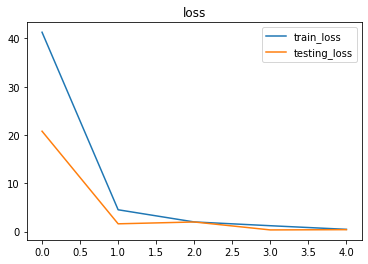

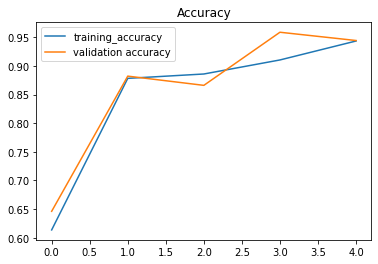

In [20]:
# plot the performance of this model

plt.plot(reshistory.history['loss'],label = 'train_loss')
plt.plot(reshistory.history['val_loss'], label = 'testing_loss')
plt.title('loss')
plt.legend()
plt.show()

plt.plot(reshistory.history['accuracy'], label='training_accuracy')
plt.plot(reshistory.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [21]:
# Evaluate the result of the prediction

result=resmodel.evaluate(validation,batch_size=128)
print(f'The test loss for ResNet 50 is {"{:.2f}".format(result[0])} and the test accuracy is {"{:.2f}".format(result[1])}')

15/15 [==============================] - 131s 9s/step - loss: 0.4067 - accuracy: 0.9444
The test loss for ResNet 50 is 0.41 and the test accuracy is 0.94


In [36]:
# ResNet101
Image_Size=[224,224]

resnet=Sequential()

resnet.add(ResNet101(input_shape=Image_Size+[3],weights='imagenet',include_top=False,pooling='average'))

# This is to ensure the base won't be trained again
for layer in resnet.layers:
    layer.trainable=False
    
flatten=Flatten()(resnet.output)
dense=Dense(256,activation='relu')(flatten)
dense=Dense(128,activation='relu')(dense)
dense=Dropout(0.2)(dense)   # We add a dropout here to prevent overfitting
prediction=Dense(3,activation='softmax')(dense)

resmodel=Model(inputs=resnet.input,outputs=prediction)

resmodel.summary()

171450368/171446536 [==============================] - 13s 0us/step
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101_input (InputLayer) [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet101 (Functional)       (None, 7, 7, 2048)        42658176  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________

In [37]:
# complile the model

resmodel.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [38]:
# fit the model to the data with the same configuration
reshistory=resmodel.fit(training,validation_data=(validation),epochs=5,verbose=1)

Epoch 1/5
33/33 [==============================] - 797s 24s/step - loss: 33.2434 - accuracy: 0.5386 - val_loss: 6.7630 - val_accuracy: 0.6833
Epoch 2/5
33/33 [==============================] - 815s 25s/step - loss: 6.5406 - accuracy: 0.7574 - val_loss: 3.3105 - val_accuracy: 0.7828
Epoch 3/5
33/33 [==============================] - 868s 26s/step - loss: 4.4983 - accuracy: 0.8626 - val_loss: 1.2820 - val_accuracy: 0.9183
Epoch 4/5
33/33 [==============================] - 716s 22s/step - loss: 1.2256 - accuracy: 0.9110 - val_loss: 0.3803 - val_accuracy: 0.9511
Epoch 5/5
33/33 [==============================] - 805s 24s/step - loss: 0.5082 - accuracy: 0.9317 - val_loss: 0.4005 - val_accuracy: 0.9500


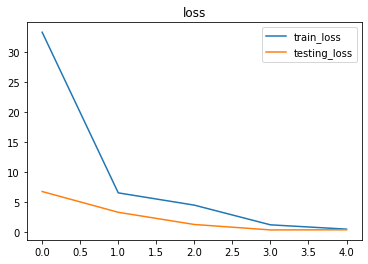

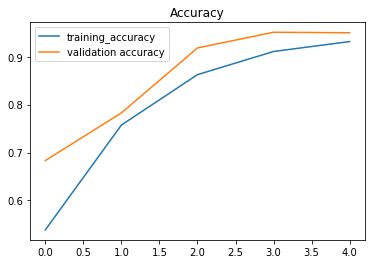

In [39]:
# plot the performance of this model

plt.plot(reshistory.history['loss'],label = 'train_loss')
plt.plot(reshistory.history['val_loss'], label = 'testing_loss')
plt.title('loss')
plt.legend()
plt.show()

plt.plot(reshistory.history['accuracy'], label='training_accuracy')
plt.plot(reshistory.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [41]:
# Evaluate the result of the prediction

result=resmodel.evaluate(validation,batch_size=128)
print(f'The test loss for ResNet 101 is {"{:.2f}".format(result[0])} and the test accuracy is {"{:.2f}".format(result[1])}')

15/15 [==============================] - 240s 16s/step - loss: 0.4005 - accuracy: 0.9500
The test loss for ResNet 101 is 0.40 and the test accuracy is 0.95


### The final prediction accuracy rate for each model follows:
### VGG16: 92%
### InceptionV3: 69%
### ResNet 50: 94%
### ResNet 101: 95%